## Tarea N°4 - Computación Científica y Ciencia de Datos
## Modelamiento estadístico de una criptomoneda
#### Semestre N°1 - 2024
**Alumno: Israel Arias Panez**

**Profesor: Pablo Román Asenjo**


---


#Introducción

El presente informe tiene como objetivo desarrollar y analizar un modelo estadístico Bayesiano aplicado al mercado de criptomonedas, específicamente utilizando datos históricos de transacciones de Bitcoin. La volatilidad intrínseca y la naturaleza especulativa de las criptomonedas presentan un desafío significativo para modelar sus comportamientos de manera precisa. Sin embargo, el uso de métodos de programación probabilística, en particular la implementación de modelos usando la librería PyMC, permite aproximar de manera efectiva los precios de cierre y otros factores relevantes.

En este contexto, se buscará construir un modelo que represente de la manera más fiel posible los datos históricos de Bitcoin, tomando como referencia la columna de precios de cierre (“close”). Además, se evaluará la capacidad de dicho modelo para describir distintos periodos que presenten distintos comportamientos. Además, se buscará hacer un segundo modelo que permita la inclusión de grandes perturbaciones del mercado, como parte de un esfuerzo por mejorar la precisión del modelo y capturar adecuadamente las dinámicas inusuales del mercado.


## Objetivos

El objetivo principal de este informe es desarrollar y evaluar un modelo estadístico Bayesiano utilizando la librería PyMC, con el fin de modelar el comportamiento del precio de cierre de Bitcoin en diferentes periodos. Los objetivos específicos de este trabajo son:

* **Construcción del Modelo Bayesiano:** Desarrollar un modelo probabilístico en PyMC que represente de manera fiel los datos históricos de precios de cierre de Bitcoin. Este modelo deberá ser capaz de capturar las dinámicas del mercado en periodos relativamente estables.

* **Selección de Datos Relevantes:** Identificar y seleccionar un subconjunto interesante de datos de Bitcoin que muestre estabilidad relativa. Esta selección permitirá evaluar la capacidad del modelo para ajustarse a diferentes segmentos de datos.

* **Análisis Comparativo:** Comparar la capacidad de ajuste del modelo en distintos periodos de tiempo, analizando si el modelo se comporta de manera más precisa en algunos segmentos que en otros, y ofreciendo una interpretación sobre las diferencias observadas.

* **Identificar Perturbaciones del Mercado:** Generar un nuevo modelo o extender el ya realizado para incluir segmentos de datos que contengan grandes caídas o subidas en los precios. Este objetivo adicional permitirá analizar cómo el modelo maneja situaciones de alta volatilidad y si puede representar adecuadamente las fluctuaciones extremas del mercado de Bitcoin.

---

#Desarrollo

In [ ]:
#Importación de librerías
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

En primer lugar, se cargan los datos:

In [ ]:
from google.colab import files

# Subir el archivo desde local
uploaded = files.upload()

Saving BTC-Daily.csv to BTC-Daily.csv


In [ ]:
# Cargar datos a un dataframe
df = pd.read_csv('BTC-Daily.csv')

# Ver las primeras filas del DataFrame para confirmar que se cargó correctamente
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


## Creación de modelo - Actividad 2

Se consigue en primer lugar un subset de datos que considera [Septiembre 2019 - Enero 2020]

In [ ]:
#Conseguir subset de 2019
# Convertir la columna 'Date' a formato de fecha
df['date'] = pd.to_datetime(df['date'])

# Filtrar los datos entre septiembre 2019 y enero 2020
df_subset = df[(df['date'] >= '2019-09-01') & (df['date'] <= '2020-01-31')]

# Ver las primeras filas del subconjunto
df_subset.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
760,1580428800,2020-01-31,BTC/USD,9510.84,9529.35,9195.93,9327.85,5009.622307,4.672901e+07
761,1580342400,2020-01-30,BTC/USD,9280.83,9570.00,9166.07,9500.00,7945.158779,7.547901e+07
762,1580256000,2020-01-29,BTC/USD,9386.57,9443.96,9215.50,9289.18,6481.915946,6.021168e+07
763,1580169600,2020-01-28,BTC/USD,8894.57,9413.24,8876.00,9400.00,9565.559355,8.991626e+07
764,1580083200,2020-01-27,BTC/USD,8600.00,9004.35,8546.55,8894.54,9619.774743,8.556347e+07


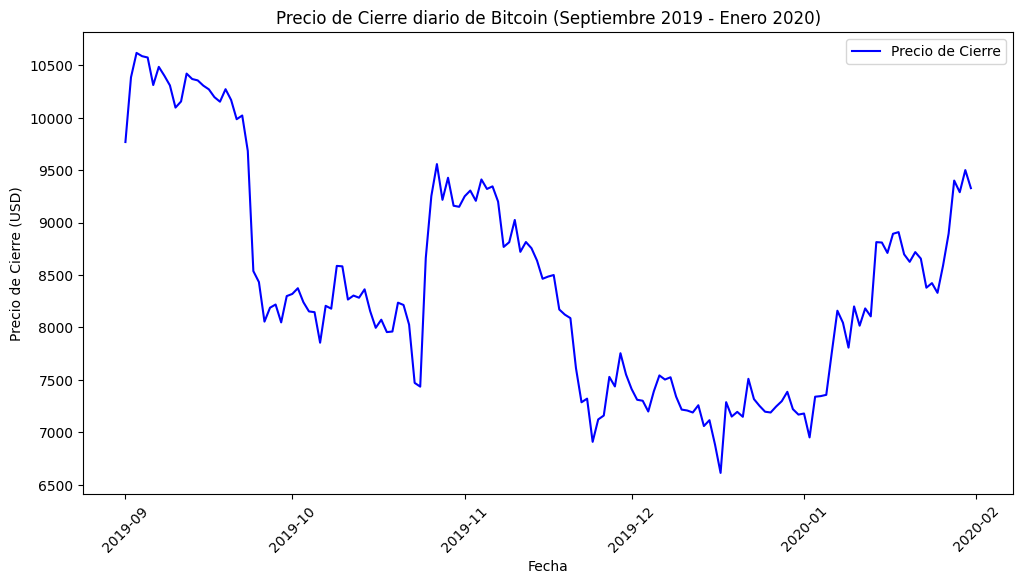

In [ ]:
# Graficar los precios de cierre en el subset de datos
plt.figure(figsize=(12, 6))
plt.plot(df_subset['date'], df_subset['close'], label='Precio de Cierre', color='blue')

# Agregar títulos y etiquetas
plt.title('Precio de Cierre diario de Bitcoin (Septiembre 2019 - Enero 2020)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.xticks(rotation=45)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Se selecciona este subconjunto en especifico debido a la forma que tiene, como se puede observar, no es “plano” en los valores que tema, es lo suficientemente interesante al presentar bajadas y subidas no tan agresivas, con lo que se podría llegar a formar un modelo.

Para la construcción del modelo, se usará la columna “close”, sin embargo, se calculará la **diferencia diaria** entre estos datos. El uso de diferencias diarias en los precios de cierre de Bitcoin en este análisis permite reducir las tendencias estacionarias a largo plazo y enfocarse en la volatilidad diaria, proporcionando una visión más clara de las fluctuaciones del mercado. Este enfoque simplifica el modelado al centrarse en los cambios relativos de un día a otro, lo que es crucial para capturar de manera efectiva la dinámica de un mercado tan volátil como el de las criptomonedas. Al trabajar con estas diferencias, se facilita la construcción de un modelo más robusto y enfocado en las variaciones diarias, mejorando la precisión del análisis.

In [ ]:
# Calcular la diferencia diaria en los precios de cierre del periodo
daily_price_diffs = np.diff(df_subset['close'].values)

# Crear un nuevo DataFrame para almacenar las diferencias diarias
df_daily_diffs = pd.DataFrame({
    'date': df_subset['date'].iloc[1:],  # Excluir el primer día porque no tiene diferencia previa
    'price_diff': daily_price_diffs
})

# Ver las primeras filas del DataFrame con las diferencias
df_daily_diffs.head()

,date,price_diff
761,2020-01-30,172.15
762,2020-01-29,-210.82
763,2020-01-28,110.82
764,2020-01-27,-505.46
765,2020-01-26,-304.06


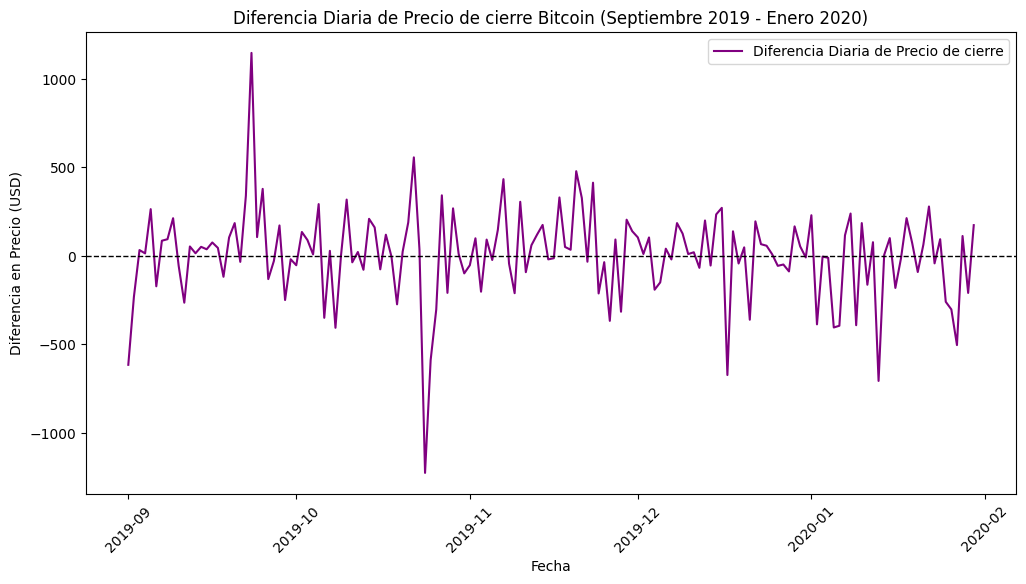

In [ ]:
# Graficar las diferencias diarias en el precio
plt.figure(figsize=(12, 6))
plt.plot(df_daily_diffs['date'], df_daily_diffs['price_diff'], label='Diferencia Diaria de Precio de cierre', color='purple')

# Agregar una línea horizontal en y = 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Agregar títulos y etiquetas
plt.title('Diferencia Diaria de Precio de cierre Bitcoin (Septiembre 2019 - Enero 2020)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia en Precio (USD)')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

A pesar de haber calculado la diferencia diaria de igual forma podemos observar grandes y pequeñas fluctuaciones, lo que hace que siga siendo igual de interesante este conjunto de datos.

El modelo propuesto busca algo similar a lo siguiente:

***Δ Precio*** ~ **S1 + S2 + S3 + S4**

Ante esto el modelo asume que la diferencia que la diferencia del precio del Bitcoin se puede descomponer como una suma de cuatro señales independientes (S1, S2, S3 y S4), en donde cada una tiene diferentes niveles de amplitud (baja, media, alta y muy alta).

Donde:

* S1 ~ Tstudent ($\nu$, $\mu$, $\sigma_1$)

* S2 ~ Normal (0, $\sigma_2$)

* S3 ~ Normal (0, $\sigma_3$)

* S4 ~ Normal (0, $\sigma_4$)

La señal S1 de baja amplitud se modela con la distribución T-Student la cual es similar a la distribución normal, sin embargo, permite el poder capturar eventos más extremos que una distribución normal no capturaría tan bien gracias a sus “colas” más extendidas, lo que para este modelo al tener mucho “ruido” en las variaciones bajas, es importante poder capturar esos cambios.

Las demás señales se modelan usando la distribución normal

La verosimilitud es la probabilidad de observar los dados datos los parámetros del modelo. En este caso finalmente la diferencia de precios observada se modela como una distribución normal centrada en la suma de las señales (S1 + S2 + S3 + S4) con una desviación estándar de 1.

Entonces, modelo:

**Δ Precio ~ Normal($\mu$ = S1+ S2 + S3 + S4, $\sigma$ = 1)**


In [ ]:
# Definir el modelo compuesto de señales
with pm.Model() as model_signals:
    # Señal 1: Ruido de baja amplitud con T student
    nu = pm.Exponential("nu", 1/10) #Grados de libertad
    sigma1 = pm.Exponential("sigma1", 1.0)
    mu_student = pm.Normal("mu", mu=0, sigma=1)

    S1 = pm.StudentT('S1', nu=nu, mu=mu_student, sigma=sigma1)

    # Señal 2: Ruido de mediana amplitud
    sigma2 = pm.HalfNormal('sigma2', sigma=2)
    S2 = pm.Normal('S2', mu=0, sigma=sigma2)

    # Señal 3: Ruido de alta amplitud
    sigma3 = pm.HalfNormal('sigma3', sigma=3)
    S3 = pm.Normal('S3', mu=0, sigma=sigma3)

    # Señal 3: Ruido de más alta amplitud
    sigma4 = pm.HalfNormal('sigma4', sigma=4)
    S4 = pm.Normal('S4', mu=0, sigma=sigma4)

    # Modelo de la diferencia como la suma de las señales
    # La suma de las señales debería igualar la diferencia de precios observada
    delta_model = S1 + S2 + S3 + S4

    # Verosimilitud: la diferencia observada modelada como la suma de las señales
    y_obs = pm.Normal('y_obs', mu=delta_model, sigma=1, observed=df_daily_diffs['price_diff'])

    # Muestreo del posterior
    trace_signals = pm.sample(1000, return_inferencedata=True)

In [ ]:
# Realizar predicciones utilizando el modelo ajustado
with model_signals:
    posterior_predictive_signals = pm.sample_posterior_predictive(trace_signals)

# Extraer las predicciones
predicciones = posterior_predictive_signals.posterior_predictive['y_obs'].mean(axis=(0, 1))

Hay un problema y es que las predicciones no están en una misma escala que los datos, sin embargo, eso es posible solucionarlo cambiando su escala, como se hará a continuación

In [ ]:
# Calcular la desviación estándar y la media de los datos reales
real_std = np.std(df_daily_diffs['price_diff'].values)
real_mean = np.mean(df_daily_diffs['price_diff'].values)

# Calcular la desviación estándar y la media de las predicciones
pred_std = np.std(predicciones)
pred_mean = np.mean(predicciones)

# Ajustar las predicciones para que coincidan en escala y media con los datos reales
adjusted_predictions = (predicciones - pred_mean) * (real_std / pred_std) + real_mean


Ahora es posible comparar de forma grafica los datos reales entre la diferencia de precio del bitcoin diaria versus los conseguidos con el modelo.

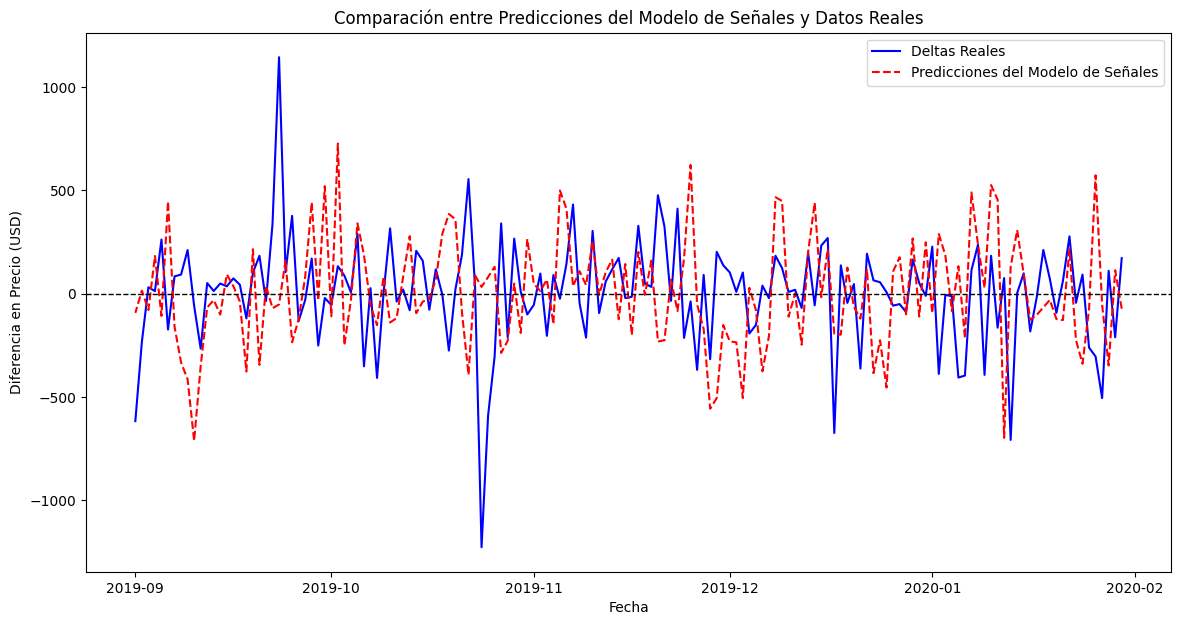

In [ ]:
# Crear el gráfico de comparación entre las diferencias reales y las predicciones
plt.figure(figsize=(14, 7))
plt.plot(df_daily_diffs['date'], df_daily_diffs['price_diff'], label='Deltas Reales', color='blue')
plt.plot(df_daily_diffs['date'], adjusted_predictions, label='Predicciones del Modelo de Señales', color='red', linestyle='dashed')
# Agregar una línea horizontal en y = 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Fecha')
plt.ylabel('Diferencia en Precio (USD)')
plt.title('Comparación entre Predicciones del Modelo de Señales y Datos Reales')
plt.legend()
plt.show()

Es posible observar que el modelo se ajusta bien al subset de datos seleccionando, de forma visual tiene diferencias, pero no considero sean tan notables a los datos originales.

Si hay que notar que aparentemente el tener las cuatro componentes de ruido distintas modeladas con su propia amplitud y distribución han permitido captarlas fluctuaciones pequeñas, pero no los peaks más extremos.


A continuación, se realizará un análisis del modelo

In [ ]:
# Resumen
az.summary(trace_signals)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
S1,0.555,1.806,-2.543,3.868,0.088,0.065,482.0,508.0,1.00
S2,0.440,1.508,-2.538,3.514,0.068,0.048,524.0,576.0,1.00
S3,0.827,1.955,-2.253,5.299,0.099,0.070,376.0,530.0,1.00
S4,1.072,2.229,-2.674,5.572,0.146,0.103,300.0,529.0,1.01
mu,0.208,1.013,-1.615,2.031,0.044,0.033,525.0,750.0,1.01
nu,10.224,10.043,0.055,29.289,0.266,0.188,541.0,256.0,1.01
sigma1,0.993,1.006,0.004,2.914,0.045,0.032,226.0,73.0,1.01
sigma2,1.519,1.072,0.019,3.435,0.042,0.030,566.0,651.0,1.00
sigma3,2.295,1.643,0.034,5.261,0.061,0.043,652.0,700.0,1.00
sigma4,2.830,2.123,0.048,6.570,0.089,0.063,452.0,748.0,1.00


Tomando en consideración los datos entregados por el resumen, el modelo de suma de señales debería de capturar eficazmente las variaciones en los precios del Bitcoin, con S3 y S4 mostrando mayor influencia debido a sus desviaciones estándar más altas, lo que indica que estas señales están diseñadas para capturar las fluctuaciones más grandes en los datos.

El uso de la distribución T-student en S1 debiese permitir manejar outliers de manera adecuada, aumentando la robustez del modelo frente a desviaciones extremas.

Los valores de r_hat cercanos a 1.00 confirman la buena convergencia del modelo, lo que refuerza aún más la fiabilidad de este modelo. Con esto en consideración se puede decir que el modelo es sólido y debería representar de forma decente las dinámicas de la diferencia de precios del Bitcoin, adaptándose de buena forma a la variabilidad observada.


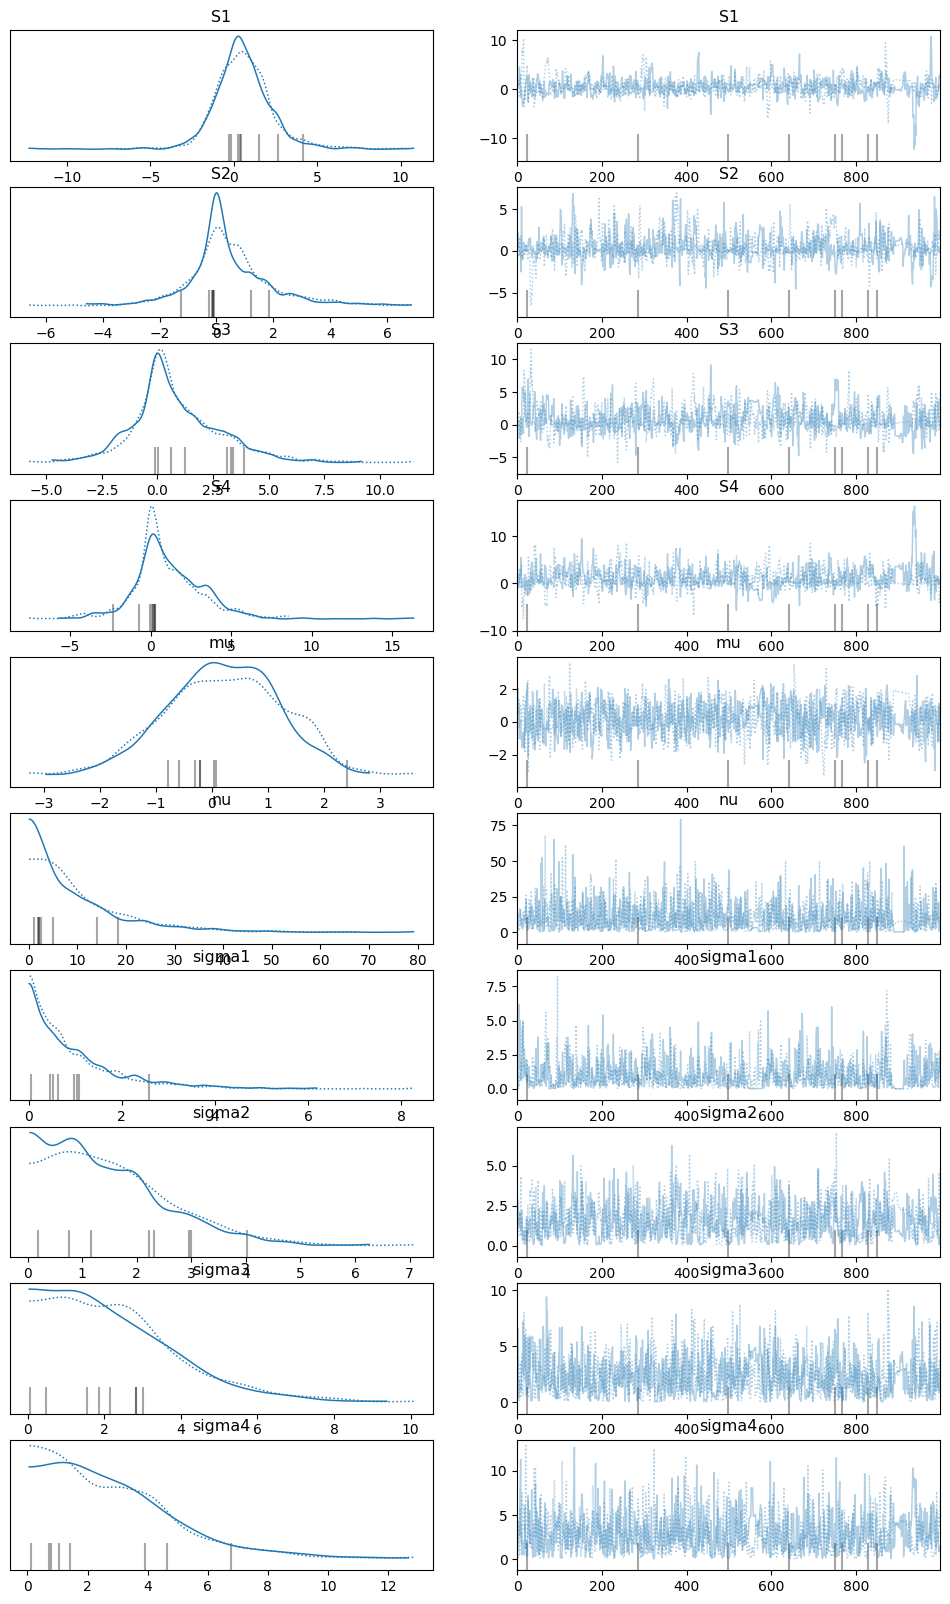

In [ ]:
# gráficos
az.plot_trace(trace_signals)
plt.show()

Considerando los gráficos del resumen, es posible observar que no presentan una gran dispersión (columna izquierda del resumen), lo que viene a apoyar la idea de que el modelo es bastante decente para modelar la diferencia de precios del bitcoin.

Finalmente, se reconstruirá el grafico original del precio de cierre del bitcoin tomando los valores diarios creados por el modelo que se ha hecho, de forma de tener una visión global si es posible extrapolar estos datos a los reales:

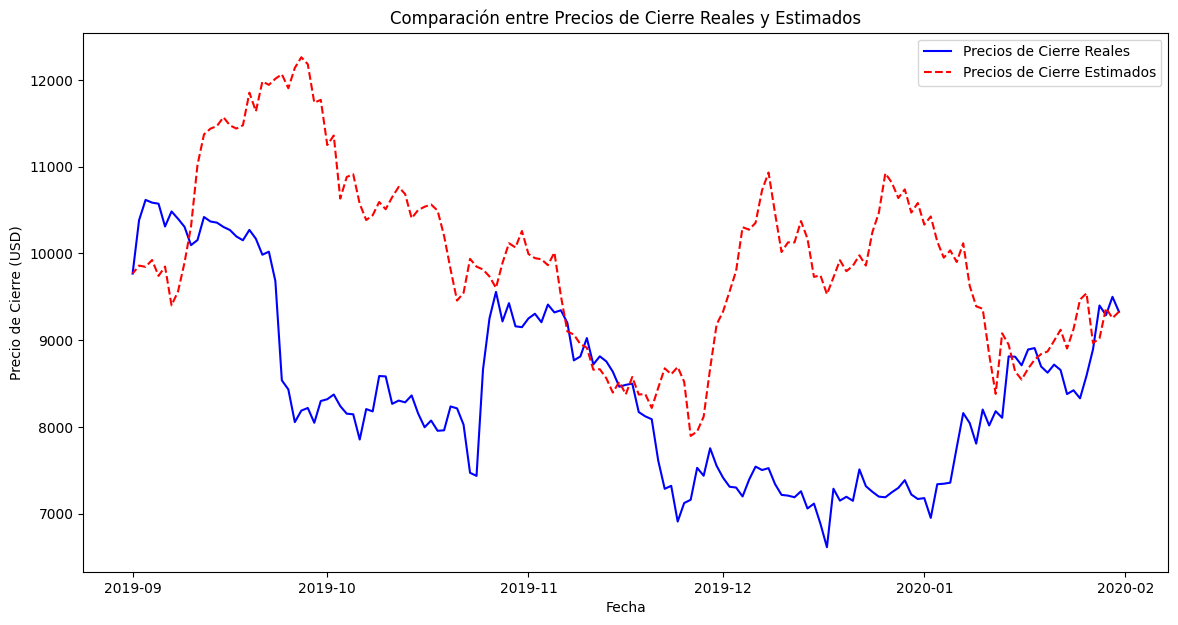

In [ ]:
# Obtener el precio de cierre inicial
initial_close_price = df_subset['close'].iloc[0]  # Primer precio de cierre del período

# Reconstruir la serie de precios de cierre a partir de las diferencias ajustadas
reconstructed_prices = np.cumsum(np.insert(adjusted_predictions, 0, initial_close_price))

# Crear el gráfico de comparación entre los precios de cierre reales y los estimados
plt.figure(figsize=(14, 7))
plt.plot(df_subset['date'], df_subset['close'], label='Precios de Cierre Reales', color='blue')
plt.plot(df_subset['date'], reconstructed_prices, label='Precios de Cierre Estimados', color='red', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.title('Comparación entre Precios de Cierre Reales y Estimados')
plt.legend()
plt.show()


Podemos observar que pareciera que los valores reconstruidos a través del modelo siguen las tendencias de subida y bajada de los valores originales de precio de cierre diarios del bitcoin, sin embargo, distan mucho en precio por ciertos periodos, por lo que no se podría decir que ocupar este approach para conseguir modelar los valores originales del precio de cierre diario sea el mejor.

Finalmente a continuación, se puede ver una visualización grafica del modelo planteado de forma matemática inicialmente.



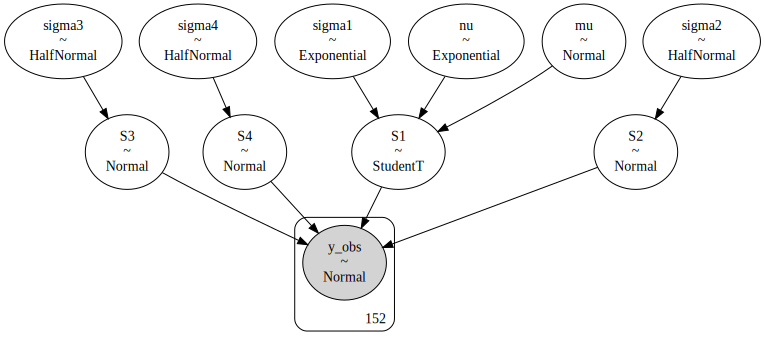

In [ ]:
pm.model_to_graphviz(model_signals)

## Comparación en otro segmento de datos - Actividad 3

En esta actividad la idea es tomar el modelo creado anteriormente y someterlo a prueba a otro segmento de datos para evaluar que sucede, ¿se ajustará de mejor o peor forma al nuevo segmento?

In [ ]:
#Conseguir nuevo subset de marzo a julio 2019

# Filtrar los datos entre septiembre 2019 y enero 2020
df_subsetB = df[(df['date'] >= '2019-03-01') & (df['date'] <= '2019-07-31')]

# Ver las primeras filas del subconjunto
df_subsetB.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
944,1564531200,2019-07-31,BTC/USD,9592.26,10143.20,9574.09,10085.34,7917.508477,7.985076e+07
945,1564444800,2019-07-30,BTC/USD,9508.21,9775.00,9373.48,9593.62,5533.971185,5.309082e+07
946,1564358400,2019-07-29,BTC/USD,9538.73,9725.17,9360.00,9495.39,5068.654309,4.812885e+07
947,1564272000,2019-07-28,BTC/USD,9467.84,9634.50,9111.00,9533.19,3860.834817,3.680607e+07
948,1564185600,2019-07-27,BTC/USD,9846.94,10235.00,9299.00,9481.37,9614.102075,9.115486e+07


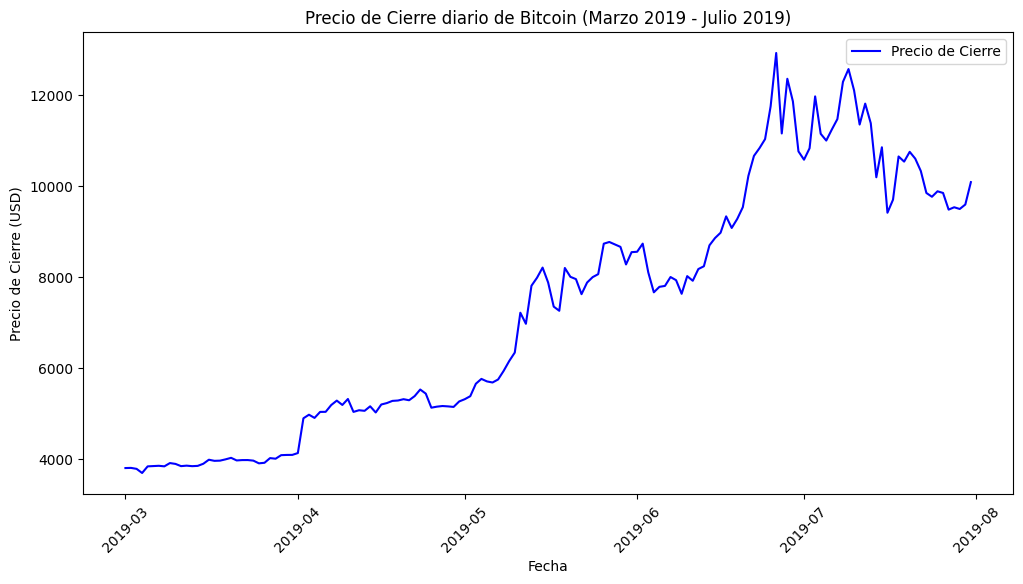

In [ ]:
# Graficar los precios de cierre en el subset de datos
plt.figure(figsize=(12, 6))
plt.plot(df_subsetB['date'], df_subsetB['close'], label='Precio de Cierre', color='blue')

# Agregar títulos y etiquetas
plt.title('Precio de Cierre diario de Bitcoin (Marzo 2019 - Julio 2019)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.xticks(rotation=45)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

En este nuevo periodo se puede ver una variación casi constante en subida al contrario en lo que se tenía en el periodo anterior, por lo que puede ser interesante ver el funcionamiento en este caso.

Al igual que para el caso anterior, se calcula la diferencia de precio diaria:

In [ ]:
# Calcular la diferencia diaria en los precios de cierre del periodo
daily_price_diffsB = np.diff(df_subsetB['close'].values)

# Crear un nuevo DataFrame para almacenar las diferencias diarias
df_daily_diffsB = pd.DataFrame({
    'date': df_subsetB['date'].iloc[1:],  # Excluir el primer día porque no tiene diferencia previa
    'price_diff': daily_price_diffsB
})

# Ver las primeras filas del DataFrame con las diferencias
df_daily_diffsB.head()

,date,price_diff
945,2019-07-30,-491.72
946,2019-07-29,-98.23
947,2019-07-28,37.80
948,2019-07-27,-51.82
949,2019-07-26,365.57


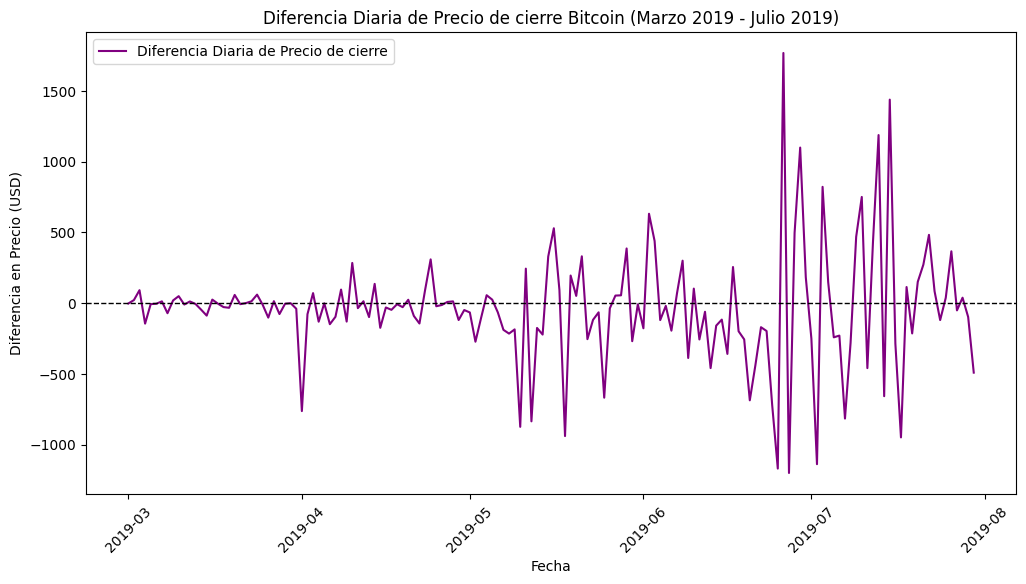

In [ ]:
# Graficar las diferencias diarias en el precio
plt.figure(figsize=(12, 6))
plt.plot(df_daily_diffsB['date'], df_daily_diffsB['price_diff'], label='Diferencia Diaria de Precio de cierre', color='purple')

# Agregar una línea horizontal en y = 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Agregar títulos y etiquetas
plt.title('Diferencia Diaria de Precio de cierre Bitcoin (Marzo 2019 - Julio 2019)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia en Precio (USD)')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Se modifica el modelo para operar con estos nuevos datos y se repite el mismo proceso realizado con anterioridad:

In [ ]:
# Definir el modelo compuesto de señales
with pm.Model() as model_signalsB:
    # Señal 1: Ruido de baja amplitud con T student
    nu = pm.Exponential("nu", 1/10) #Grados de libertad
    sigma1 = pm.Exponential("sigma1", 1.0)
    mu_student = pm.Normal("mu", mu=0, sigma=1)

    S1 = pm.StudentT('S1', nu=nu, mu=mu_student, sigma=sigma1)

    # Señal 2: Ruido de mediana amplitud
    sigma2 = pm.HalfNormal('sigma2', sigma=2)
    S2 = pm.Normal('S2', mu=0, sigma=sigma2)

    # Señal 3: Ruido de alta amplitud
    sigma3 = pm.HalfNormal('sigma3', sigma=3)
    S3 = pm.Normal('S3', mu=0, sigma=sigma3)

    # Señal 3: Ruido de más alta amplitud
    sigma4 = pm.HalfNormal('sigma4', sigma=4)
    S4 = pm.Normal('S4', mu=0, sigma=sigma4)

    # Modelo de la diferencia como la suma de las señales
    # La suma de las señales debería igualar la diferencia de precios observada
    delta_modelB = S1 + S2 + S3 + S4

    # Verosimilitud: la diferencia observada modelada como la suma de las señales
    y_obsB = pm.Normal('y_obs', mu=delta_modelB, sigma=1, observed=df_daily_diffsB['price_diff'])

    # Muestreo del posterior
    trace_signalsB = pm.sample(1000, return_inferencedata=True)

In [ ]:
# Realizar predicciones utilizando el modelo ajustado
with model_signalsB:
    posterior_predictive_signalsB = pm.sample_posterior_predictive(trace_signalsB)

# Extraer las predicciones
prediccionesB = posterior_predictive_signalsB.posterior_predictive['y_obs'].mean(axis=(0, 1))

In [ ]:
# Calcular la desviación estándar y la media de los datos reales
real_stdB = np.std(df_daily_diffsB['price_diff'].values)
real_meanB = np.mean(df_daily_diffsB['price_diff'].values)

# Calcular la desviación estándar y la media de las predicciones
pred_stdB = np.std(prediccionesB)
pred_meanB = np.mean(prediccionesB)

# Ajustar las predicciones para que coincidan en escala y media con los datos reales
adjusted_predictionsB = (prediccionesB - pred_meanB) * (real_stdB / pred_stdB) + real_meanB

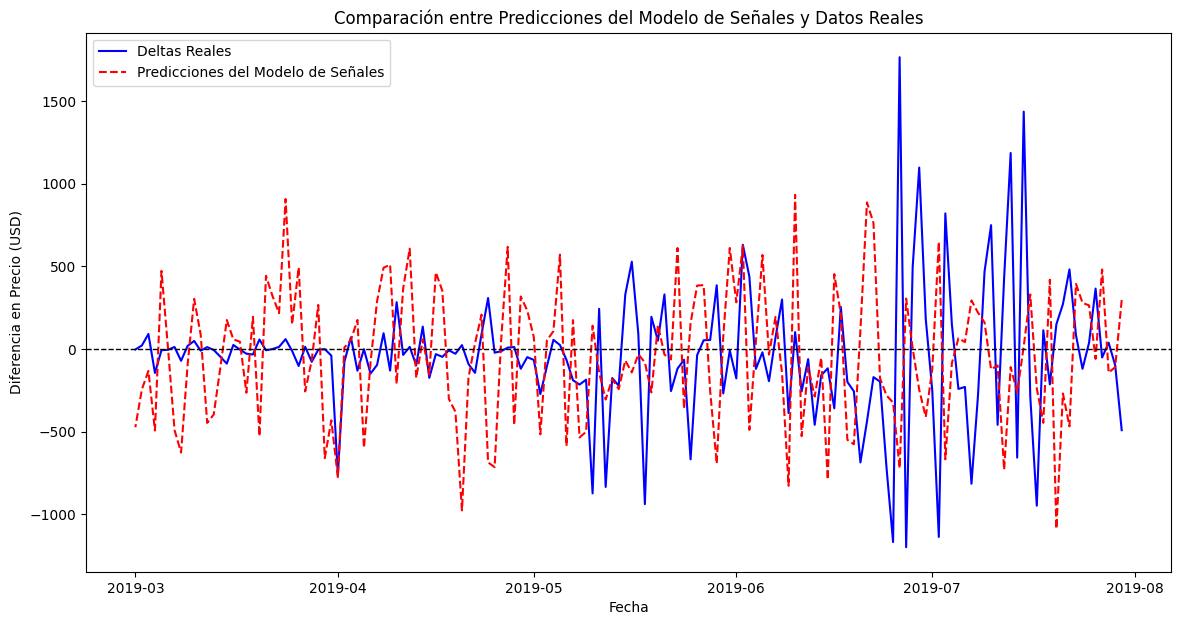

In [ ]:
# Crear el gráfico de comparación entre las diferencias reales y las predicciones
plt.figure(figsize=(14, 7))
plt.plot(df_daily_diffsB['date'], df_daily_diffsB['price_diff'], label='Deltas Reales', color='blue')
plt.plot(df_daily_diffsB['date'], adjusted_predictionsB, label='Predicciones del Modelo de Señales', color='red', linestyle='dashed')
# Agregar una línea horizontal en y = 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Fecha')
plt.ylabel('Diferencia en Precio (USD)')
plt.title('Comparación entre Predicciones del Modelo de Señales y Datos Reales')
plt.legend()
plt.show()

Es posible observar que para este nuevo segmento de datos que las predicciones parecen ser mucho más volátiles que los datos reales, pero parece que sigue adecuadamente la tendencia en general del precio del bitcoin en la mayoría del segmento de tiempo, sin embargo, no es capaz de captar de buena forma las grandes variaciones, fenomeno que también se pudo observar en el segmento de datos de la actividad n°2.

In [ ]:
# Resumen
az.summary(trace_signalsB)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
S1,-39.975,4.037,-48.626,-32.468,0.211,0.149,350.0,232.0,1.56
S2,-0.125,1.359,-2.640,2.798,0.050,0.115,870.0,113.0,1.66
S3,-0.136,1.962,-4.189,3.833,0.063,0.223,849.0,86.0,1.57
S4,-1.067,3.244,-7.464,4.727,0.173,0.172,152.0,169.0,1.47
mu,0.188,0.753,-1.426,1.694,0.163,0.148,13.0,69.0,1.62
nu,0.391,0.748,0.006,1.163,0.164,0.117,7.0,61.0,1.53
sigma1,1.112,1.104,0.020,3.174,0.348,0.253,19.0,60.0,1.67
sigma2,0.810,1.160,0.017,2.996,0.572,0.437,3.0,24.0,2.06
sigma3,1.254,1.670,0.049,4.464,0.863,0.665,3.0,13.0,1.82
sigma4,2.697,1.958,0.034,6.585,0.382,0.294,126.0,78.0,1.59


El modelo sugiere que S1 tiene una gran influencia negativa en el precio, mientras que S2, S3, y S4 tienen un impacto mucho menor. Sin embargo, los altos valores de r_hat  (mayores a 1.5) indican que el modelo no ha convergido bien, lo que significa que las estimaciones pueden no ser confiables.

Esto, junto con la alta variabilidad observada en las señales y las pocas muestras efectivas, sugiere que el modelo no está ajustándose adecuadamente a los datos, lo que finalmente nos permite entender de mejor manera el grafico presentado antes y concluir que realmente para la actividad n°2 se ajustaba mucho mejor que para este nuevo conjunto de datos.

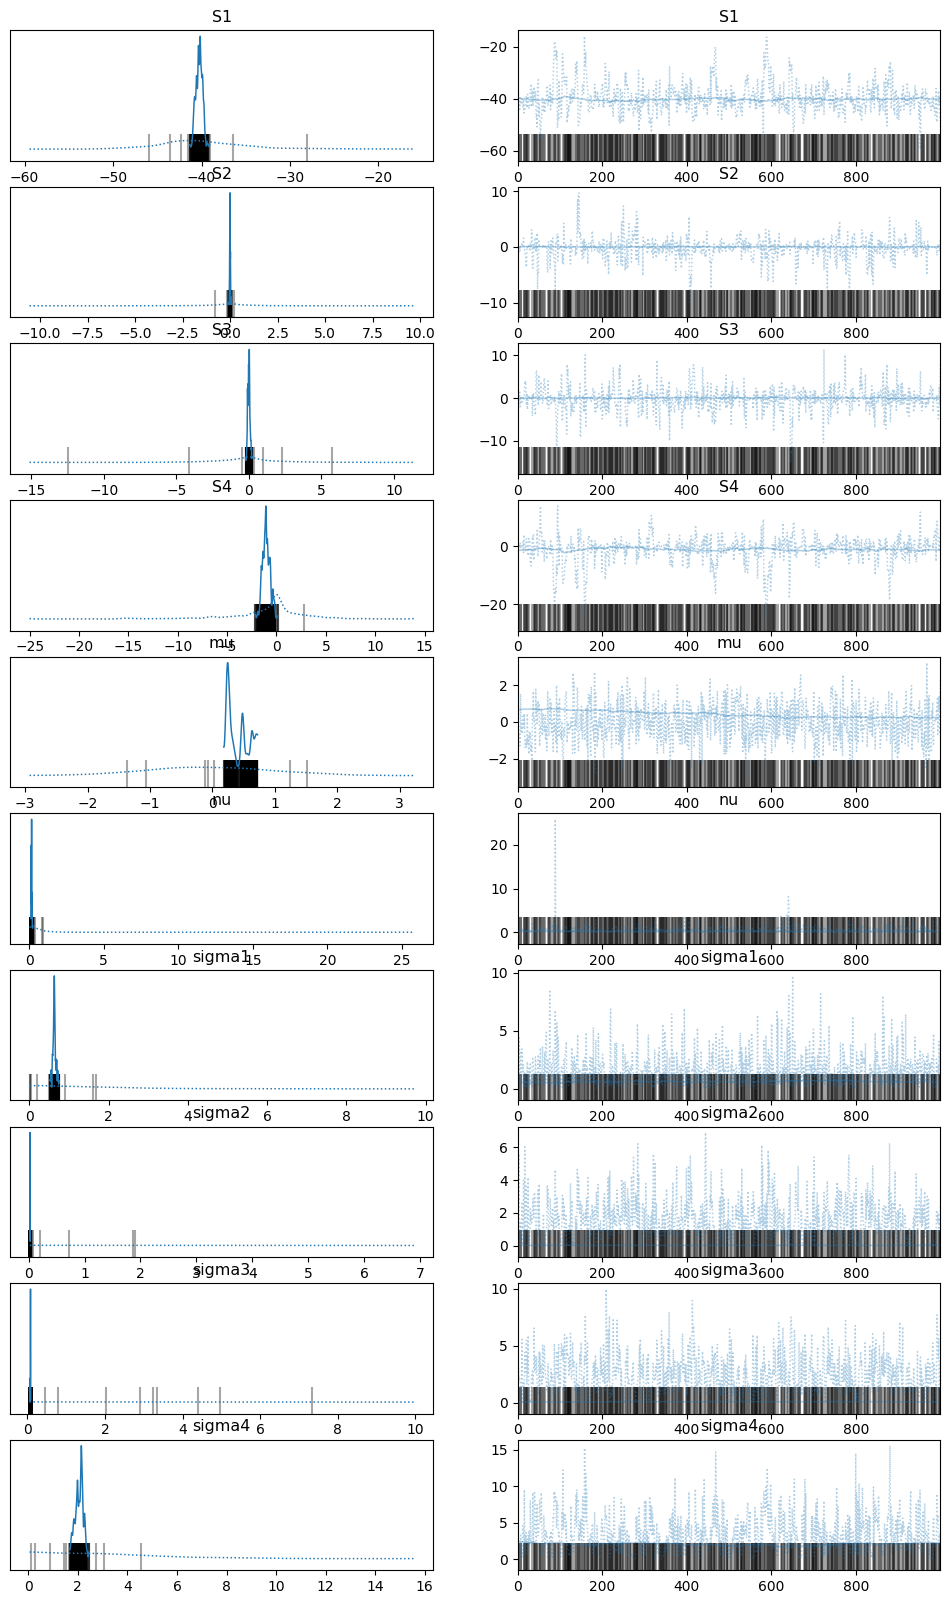

In [ ]:
# gráficos
az.plot_trace(trace_signalsB)
plt.show()

Siguiendo la idea, el resumen lo deja mucho más en claro, la dispersión es muy grande, definitivamente este modelo no se ajusta bien para este nuevo conjunto de datos, al contrario que en la actividad n°2.

Tomando en consideración lo realizado en la actividad n°2 y en esta actividad, es posible concluir que el modelo definitivamente no es capaz de captar grandes fluctuaciones del precio del bitcoin, como ocurren aquí (Ver gráfico con línea azul inicial de esta sección), pero el modelo es bastante adecuado cuando se tienen periodos estables como en la actividad n°2.


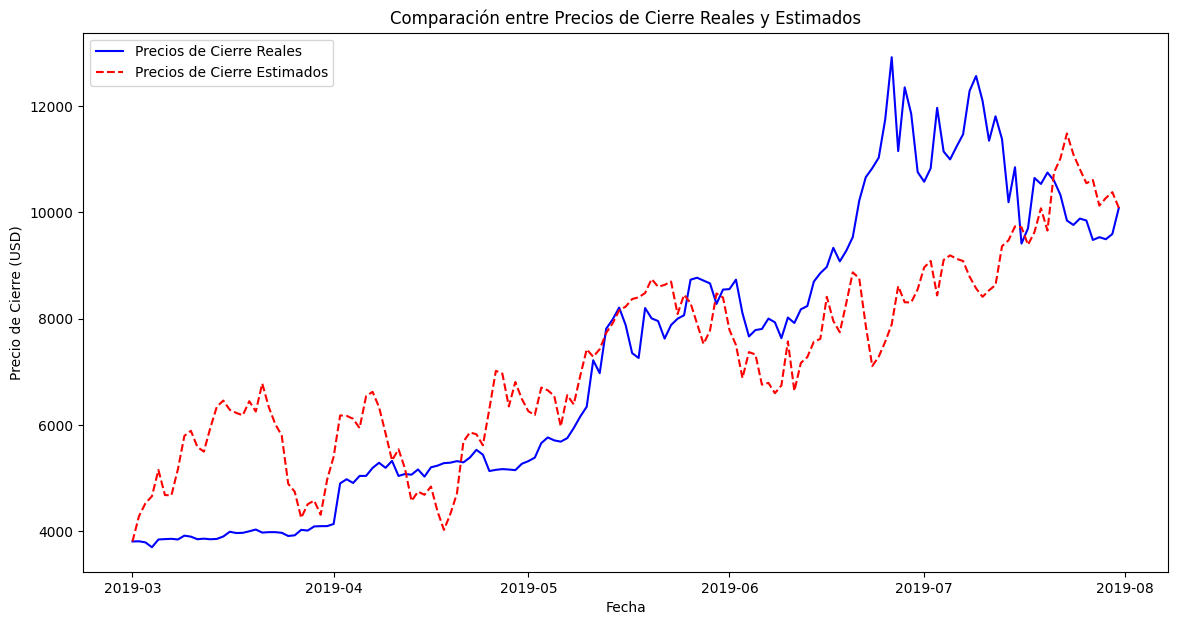

In [ ]:
# Obtener el precio de cierre inicial
initial_close_priceB = df_subsetB['close'].iloc[0]  # Primer precio de cierre del período

# Reconstruir la serie de precios de cierre a partir de las diferencias ajustadas
reconstructed_pricesb = np.cumsum(np.insert(adjusted_predictionsB, 0, initial_close_priceB))

# Crear el gráfico de comparación entre los precios de cierre reales y los estimados
plt.figure(figsize=(14, 7))
plt.plot(df_subsetB['date'], df_subsetB['close'], label='Precios de Cierre Reales', color='blue')
plt.plot(df_subsetB['date'], reconstructed_pricesb, label='Precios de Cierre Estimados', color='red', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.title('Comparación entre Precios de Cierre Reales y Estimados')
plt.legend()
plt.show()

Finalmente se reconstruye el grafico de precio de cierre inicial y se compara al original, podemos ver que a pesar de que no es muy exacto y le cuesta identificar los peaks, definitivamente parece seguir de forma general la tendencia de precios, siendo esta la misma conclusión alcanzada anteriormente.

## Bonus - Actividad 4

En esta actividad 4 de bonus se intentará el construir un modelo que sea capaz de reaccionar a las variaciones bruscas de precios y pueda estimar las frecuencias de estas.

In [ ]:
# Filtrar los datos entre octubre 2018 y enero 2019
df_subsetC = df[(df['date'] >= '2018-09-01') & (df['date'] <= '2019-01-31')]

# Ver las primeras filas del subconjunto
df_subsetC.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
1125,1548892800,2019-01-31,BTC/USD,3438.00,3474.20,3392.60,3413.11,5951.818170,2.031421e+07
1126,1548806400,2019-01-30,BTC/USD,3391.25,3465.05,3372.34,3437.35,5704.023402,1.960672e+07
1127,1548720000,2019-01-29,BTC/USD,3431.43,3438.76,3322.19,3390.50,7284.386863,2.469771e+07
1128,1548633600,2019-01-28,BTC/USD,3532.23,3536.77,3357.30,3429.50,10345.100910,3.547852e+07
1129,1548547200,2019-01-27,BTC/USD,3555.31,3564.12,3456.00,3533.23,3852.659641,1.361233e+07


In [ ]:
df['date'].min()

Timestamp('2014-11-28 00:00:00')

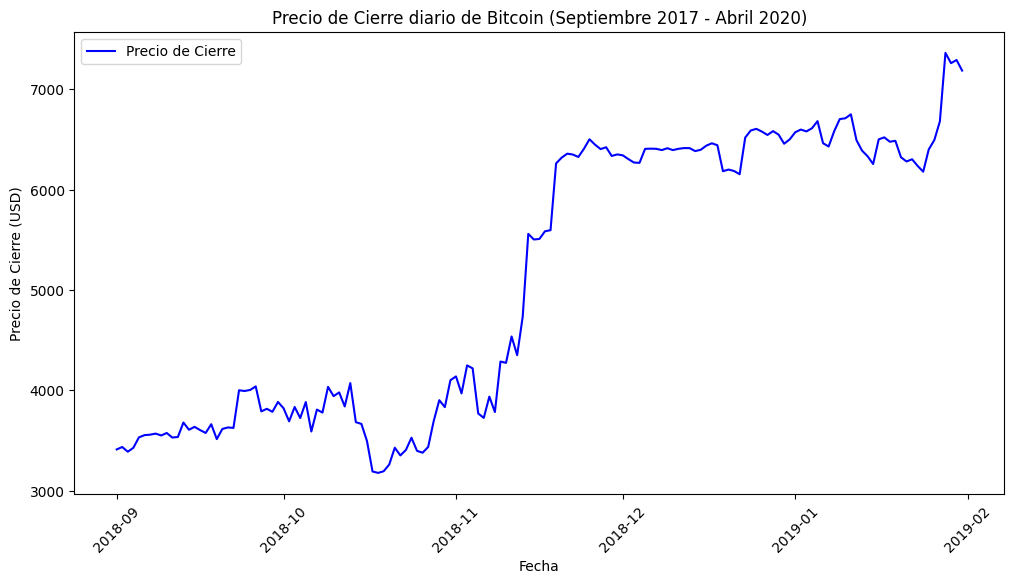

In [ ]:
# Graficar los precios de cierre en el subset de datos
plt.figure(figsize=(12, 6))
plt.plot(df_subsetC['date'][::-1], df_subsetC['close'], label='Precio de Cierre', color='blue')

# Agregar títulos y etiquetas
plt.title('Precio de Cierre diario de Bitcoin (Septiembre 2017 - Abril 2020)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.xticks(rotation=45)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

El espacio temporal elegido es preciso para intentar generar un modelo que sea capaz de identificar variaciones muy grandes en el precio, como podemos ver de forma clara, hay una gran variación entre noviembre y diciembre de 2018.

A continuación, se procede a definir y construir el modelo que busca poder detectar estos cambios bruscos en el tiempo:


- **$P_t \sim \text{Poisson}(r_t)$**  
  Donde $P_t$ representa el precio de cierre del Bitcoin en el día $t$. Se asume que este sigue un proceso de Poisson con un parámetro de tasa $r_t$.

- **$r_t =$**  
  - $e$, si $t \leq s$  
  - $l$, si $t > s$  
  Aquí, $r_t$ es la tasa del proceso de Poisson que cambia en un punto $s$. Antes de $s$, la tasa es $e$ y después de $s$, la tasa es $l$.

- **$s \sim \text{Uniform}(t_l, t_h)$**  
  $s$ es el día en que se produce el cambio en la tasa de variación del precio del Bitcoin. Se modela como una variable uniforme discreta que puede ocurrir en cualquier momento entre $t_l$ y $t_h$, donde $t_l$ y $t_h$ son los límites inferiores y superiores del tiempo considerado.

- **$e \sim \text{Exp}(1)$**  
  $e$ es la tasa del proceso de Poisson antes del punto de cambio $s$. Se modela con una distribución exponencial.

- **$l \sim \text{Exp}(1)$**  
  $l$ es la tasa del proceso de Poisson después del punto de cambio $s$. También se modela con una distribución exponencial.
  

---


- ***Explicación del Modelo***

- **$P_t$ (Precio de Cierre):**  
  Esta variable representa el precio de cierre diario del Bitcoin en un día específico $t$. Se modela como una realización de un proceso de Poisson, lo que implica que la ocurrencia del precio en un día dado es aleatoria, pero con una cierta tasa que controla la frecuencia de estas ocurrencias.

- **$r_t$ (Tasa de Cambio del Precio):**  
  La tasa $r_t$ cambia en un punto específico $s$, lo que refleja un cambio en la dinámica del mercado del Bitcoin. Antes de este punto, la tasa es $e$, y después, la tasa es $l$. Este cambio podría estar relacionado con un evento significativo en el mercado, como un cambio en la regulación, un evento macroeconómico, o un cambio en la percepción de valor del Bitcoin.

- **$s$ (Punto de Cambio):**  
  Es el día en el que ocurre un cambio significativo en la dinámica del precio del Bitcoin. Este punto se modela como una variable aleatoria uniforme, indicando que puede ocurrir en cualquier momento dentro del intervalo temporal considerado.

- **$e$ y $l$ (Tasas Antes y Después del Cambio):**  
  Estas tasas controlan la frecuencia del cambio en el precio del Bitcoin antes y después del punto de cambio $s$. Se asume que estas tasas siguen distribuciones exponenciales, lo que permite modelar una variedad de posibles escenarios de cambio en la dinámica de precios.


El modelo asume que los precios de cierre del Bitcoin siguen un proceso de Poisson con una tasa que cambia en un punto determinado $s$. Antes de $s$, el precio sigue un proceso con una tasa $e$, y después de $s$, sigue un proceso con una tasa $l$. La idea es identificar este punto de cambio y las respectivas tasas para poder detectar cambios bruscos.

Este modelo debería permitir identificar cambios significativos en la tendencia de los precios.


In [ ]:
# Se realiza un arreglo de dias para poder crear una distribucion uniforme discreta
days = np.arange(len(df_subsetC['date']))

In [ ]:
len(days)

153

In [ ]:
len(df_subsetC['close'])

153

In [ ]:
# Definir el modelo para detectar grandes subidas o caidas de precios
with pm.Model() as bitcoin_model:
    # Definir el punto de cambio en el tiempo (fecha)
    switchpoint = pm.DiscreteUniform("switchpoint", lower=days.min(), upper=days.max())

    # Tasas de cambio en el precio de cierre antes y después del punto de cambio
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Definir la tasa para cada día en función de si es antes o después del punto de cambio
    rate = pm.math.switch(switchpoint >= days, early_rate, late_rate)

    # Modelo de los precios de cierre como un proceso de Poisson
    price_model = pm.Poisson("price_model", rate, observed=df_subsetC['close'])


In [ ]:
with bitcoin_model:
    idata = pm.sample(10000)

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


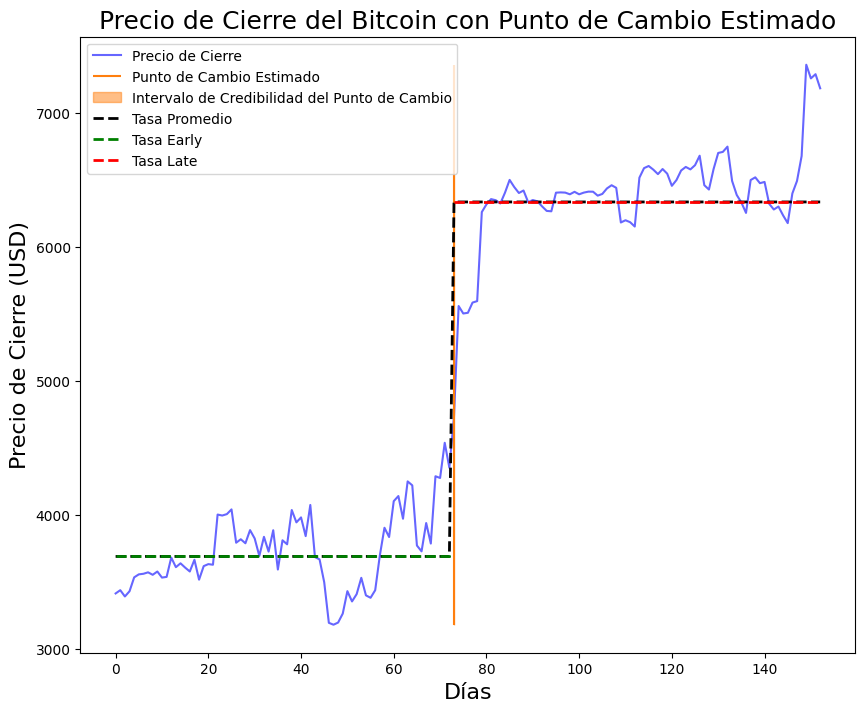

In [ ]:
plt.figure(figsize=(10, 8))

# línea continua para los datos originales
plt.plot(days, df_subsetC['close'], "-", alpha=0.6, color="blue", label="Precio de Cierre")

plt.ylabel("Precio de Cierre (USD)", fontsize=16)
plt.xlabel("Días", fontsize=16)

#  línea vertical en el punto de cambio promedio
trace = idata.posterior.stack(draws=("chain", "draw"))
switchpoint_mean = trace["switchpoint"].mean()
plt.vlines(switchpoint_mean, df_subsetC['close'].min(), df_subsetC['close'].max(), color="C1", label="Punto de Cambio Estimado")

# Calcular y trazar la tasa promedio de variación
average_disasters = np.zeros_like(df_subsetC['close'], dtype="float")
for i, year in enumerate(days):
    idx = year < switchpoint_mean
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

# Rellenar el área del intervalo de credibilidad del punto de cambio
sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[df_subsetC['close'].min(), df_subsetC['close'].max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
    label="Intervalo de Credibilidad del Punto de Cambio"
)

#  línea discontinua para la tasa promedio de variación
plt.plot(days, average_disasters, "k--", lw=2, label="Tasa Promedio")

# Trazar las tasas early_rate y late_rate como líneas horizontales
early_rate_mean = trace["early_rate"].mean()
late_rate_mean = trace["late_rate"].mean()

plt.hlines(early_rate_mean, days.min(), switchpoint_mean, color="green", linestyle="--", lw=2, label="Tasa Early")
plt.hlines(late_rate_mean, switchpoint_mean, days.max(), color="red", linestyle="--", lw=2, label="Tasa Late")

# Añadir una leyenda para mayor claridad
plt.legend()

plt.title("Precio de Cierre del Bitcoin con Punto de Cambio Estimado", fontsize=18)
plt.show()


El modelo estima un punto de cambio crítico alrededor del día 70, marcando un momento en el cual la tendencia del precio del Bitcoin se altera significativamente.

Antes del punto de cambio, la tasa de variación del precio, representada por la "Tasa Early", es baja y estable, indicando un período de calma en el mercado. Después del punto de cambio, la "Tasa Late" refleja un incremento en la tendencia del precio, esto sugiriendo un nuevo comportamiento más dinámico y posiblemente alcista. El intervalo de credibilidad que rodea el punto de cambio muestra la incertidumbre en la estimación, pero también confirma que el modelo ha capturado correctamente el momento de transición en la dinámica del mercado.
En resumen, el modelo propuesto ha identificado eficazmente los puntos de inflexión en la tendencia del precio del Bitcoin para el set de datos especificado, proporcionando una estimación clara de las tasas de variación antes y después del cambio.


array([[<Axes: title={'center': 'early_rate'}>,
        <Axes: title={'center': 'early_rate'}>],
       [<Axes: title={'center': 'late_rate'}>,
        <Axes: title={'center': 'late_rate'}>],
       [<Axes: title={'center': 'switchpoint'}>,
        <Axes: title={'center': 'switchpoint'}>]], dtype=object)

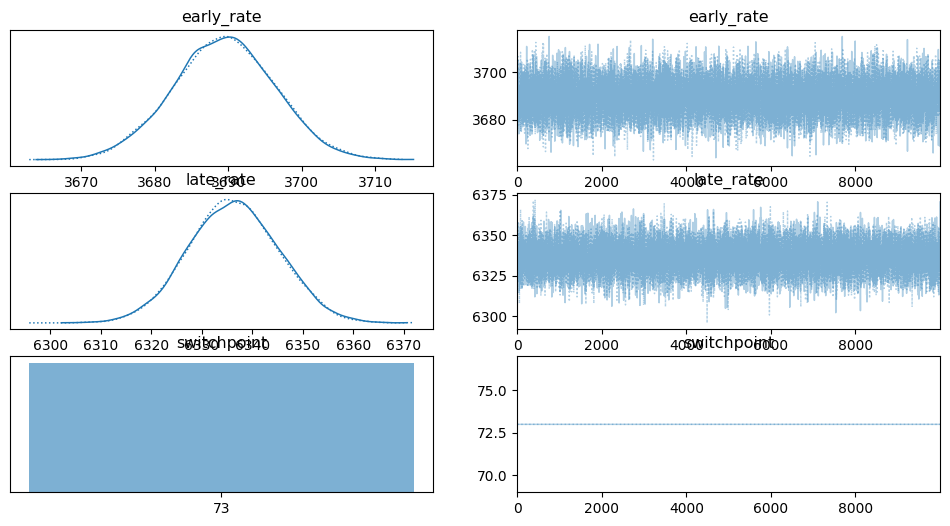

In [ ]:
az.plot_trace(idata)

Además, no hay mucha dispersión en los parametros, lo que confirma que este modelo es capaz de detectar variaciones bruscas como se vio anteriormente.

La única forma de concluir si puede detectar el ratio de estas variaciones sería modelándolo para un conjunto muy grande de fechas.


# Conclusiones

## Análisis de los resultados

Respecto a la actividad 2 y 3, se puede notar que el modelo creado definitivamente se ajusta bien a datos donde no hay grandes variaciones, que tienen una tendencia algo estática y puede ser útil para estudiar este tipo de periodos, pero no es un buen modelo cuando se tienen grandes variaciones en el precio del bitcoin.

Respecto a la actividad 4 se logro el implementar un modelo que es capaz de detectar fluctuaciones grandes de precio del bitcoin, como quedo demostrado para el set de datos seleccionados. Podría hacerse el estudio de si es capaz de detectar el ratio de estos, pero para esto se necesita una mayor cantidad de periodos y datos.


## Resumen de la experiencia

En conclusión, este trabajo demuestra que el uso de modelos para analizar las diferencias diarias en los precios de cierre de Bitcoin proporciona una herramienta efectiva para poder estudiar este mercado (pero no predecir futuros acontecimientos). A través de la selección adecuada de datos y la comparación de diferentes segmentos temporales, se ha logrado un entendimiento más profundo de las dinámicas del mercado, mostrando que los modelos probabilísticos pueden describir con precisión tanto periodos de estabilidad como eventos de alta volatilidad.